# Inventory management using Monte Carlo Simulation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('whitegrid')

In [3]:
data = pd.read_excel('inventory_data.xlsx')

In [4]:
data.head()

,Day,Product 1,Product 2,Product 3,Product 4
0,0,90,610,204,153
1,1,94,685,244,147
2,2,0,649,197,0
3,3,110,667,0,0
4,4,106,663,228,0


In [5]:
column_names = list(data.columns)[1:]

Demand distribution of each product

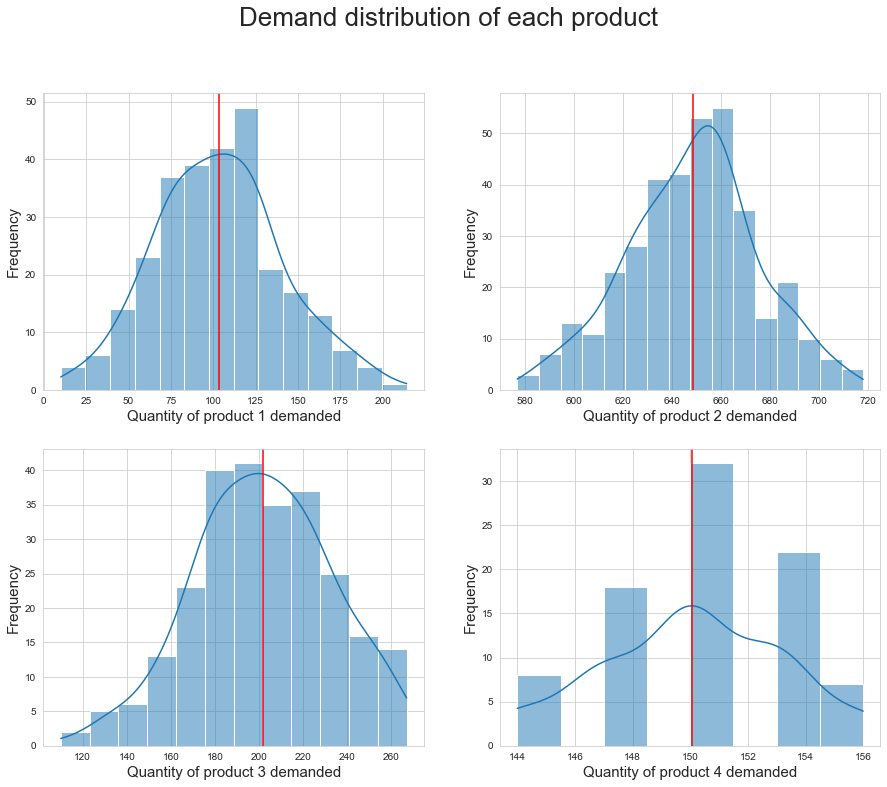

In [6]:
fig, ax = plt.subplots(2,2, figsize=(15,12))
x_labels = ["Quantity of product 1 demanded", 
            "Quantity of product 2 demanded", 
            "Quantity of product 3 demanded", 
            "Quantity of product 4 demanded"]
y_labels = ["Frequency", "Frequency", "Frequency", "Frequency"]
for idx, c in enumerate(column_names):
    col = idx%2
    row = idx//2
    sns.histplot(data=data, x=data[data[c]!= 0][c], kde=True, ax=ax[row,col])
    ax[row, col].set_xlabel(x_labels[idx], fontsize=15)
    ax[row, col].set_ylabel(y_labels[idx], fontsize=15)
    ax[row, col].axvline(x=data[data[c]!= 0][c].mean(),color='red')

fig.suptitle('Demand distribution of each product', fontsize=26)
plt.show()

In [7]:
data.describe()

,Day,Product 1,Product 2,Product 3,Product 4
count,366.000000,366.000000,366.000000,366.000000,366.000000
mean,182.500000,78.333333,648.551913,141.614754,35.672131
std,105.799338,55.080000,26.483001,95.964187,63.987684
min,0.000000,0.000000,577.000000,0.000000,0.000000
25%,91.250000,18.000000,631.000000,0.000000,0.000000
50%,182.500000,86.000000,650.000000,182.000000,0.000000
75%,273.750000,119.500000,664.000000,214.500000,0.000000
max,365.000000,214.000000,718.000000,267.000000,156.000000


In [8]:
prod_info = pd.read_excel('product_summary.xlsx')

In [9]:
prod_info

,Product,Purchase Cost,Lead Time,Selling Price,Starting Stock,Ordering cost,Holding cost,Size,Mean_demand,Std_dev_demand,Demand_lead
0,1,12,9,16.1,2750,1000,20,0.570,103.501805,37.317994,705
1,2,7,6,8.6,22500,1200,20,0.052,648.551913,26.446797,3891
2,3,6,16,10.2,5200,1000,20,0.530,201.677043,31.079301,2266
3,4,37,22,68.0,1400,1200,20,1.050,150.068965,3.215598,785


In [10]:
order_probability = [] #Probability of placing an order on any given day

for p in column_names:
    order_probability.append(round((((data[p] != 0).sum())/365),2)) #Number of days the product was demanded/total number of working days

In [11]:
prod_info['Order Probability'] = order_probability

In [12]:
prod_info

,Product,Purchase Cost,Lead Time,Selling Price,Starting Stock,Ordering cost,Holding cost,Size,Mean_demand,Std_dev_demand,Demand_lead,Order Probability
0,1,12,9,16.1,2750,1000,20,0.570,103.501805,37.317994,705,0.76
1,2,7,6,8.6,22500,1200,20,0.052,648.551913,26.446797,3891,1.00
2,3,6,16,10.2,5200,1000,20,0.530,201.677043,31.079301,2266,0.70
3,4,37,22,68.0,1400,1200,20,1.050,150.068965,3.215598,785,0.24


- **Product**	: Product number
- **Purchase Cost** : Cost price of product
- **Lead Time** : Number of days elapsed between placing the order for the product and receiving the product
- **Profit %** : Profit markup on the product
- **Selling Price** : Price at which product is sold
- **Starting Stock** : Inventory at the beginning of the year
- **Ordering cost** : cost of placing an order for the product each time
- **Holding cost** : Total cost of holding a unit of that product for a year
- **Size** : size of the product
- **Order Probability** : how frequently is the product bought
- **Average Demand per day** : average quantity sold each day
- **Std Dev of Demand per day** : Std dev of the demand
- **Avg Demand during leadtime** : Quantity expected to be sold during lead time

In [13]:
class Product:
    def __init__(self, i):
        self.cost = prod_info['Purchase Cost'].iloc[i-1]
        self.lead_time = prod_info['Lead Time'].iloc[i-1]
        self.selling_price = prod_info['Selling Price'].iloc[i-1]
        self.starting_stock = prod_info['Starting Stock'].iloc[i-1]
        self.ordering_cost = prod_info['Ordering cost'].iloc[i-1]
        self.holding_cost = prod_info['Holding cost'].iloc[i-1]
        self.size = prod_info['Size'].iloc[i-1]
        self.probability = prod_info['Order Probability'].iloc[i-1]
        self.leadtime_demand = prod_info['Demand_lead'].iloc[i-1]
        
        self.mean = np.mean([np.log(x) for x in data[data['Product ' + str(i)] > 0]['Product ' + str(i)]]) #convert values into log and calculate the mean
        self.std = np.std([np.log(x) for x in data[data['Product ' + str(i)] > 0]['Product ' + str(i)]])

In [61]:
def daily_demand(mean, std, probability): #converting demand into log normal
    random_num = np.random.uniform(0,1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, std))

### PERIODIC REVIEW

In [62]:
# 1 Monte carlo simulation for M level of inventory.

def monte_carlo(product, M, review_period = 30):# M = level of inventory
    inventory = product.starting_stock
    lead_demand = product.leadtime_demand
    lead_time = product.lead_time
    mean = product.mean
    std = product.std
    probability = product.probability
    
    data_dict = {'orders' : [], 'per_day_demand' : [], 'orders_lost' : [],
                 'quantity_sold' : [], 'inventory_level' : []} 
    
    q = 0 # Quantity of order to be placed
    counter = 0 # number of days elapsed since the order was placed
    out_of_stock = 0 # number of times store was out of stock for a product
    order_placed = False
    
    for d in range(1,366):
        day_demand = daily_demand(mean,std,probability)
        data_dict['per_day_demand'].append(day_demand)
                                     
        # Place order on 30th day since last order
        if d % review_period == 0:
            q = M - inventory + lead_demand
            order_placed = True
            data_dict['orders'].append(q)
            
        # If the order placed switch is on, increase the counter by 1.
        # This increases the number of days elapsed since order was placed,by 1.
        if order_placed:
            counter += 1
        
        # Replenishment day
        if counter == lead_time: #counter == lead_time + 1 ??
            inventory += q
            order_placed = False
            counter = 0
        
        # If daily demand can be fulfilled by the current inventory level, reduce the inventory
        # level by the demand.
        if inventory - day_demand >= 0:
            data_dict['quantity_sold'].append(day_demand)
            inventory -= day_demand
        
        # If demand cannot be fulfilled by the current inventory stock, quantity sold will be
        # the inventory stock left. Order lost = Daily demand - inventory level
        elif inventory - day_demand < 0:
            data_dict['quantity_sold'].append(inventory)
            data_dict['orders_lost'].append(day_demand - inventory)
            inventory = 0
            out_of_stock += 1

        
        data_dict['inventory_level'].append(inventory)
#         data_dict['stock_out'].append(out_of_stock)
    return data_dict

In [63]:
def profit(product, data_dict):
    cost_price = product.cost
    selling_price = product.selling_price
    ordering_cost = product.ordering_cost
    holding_cost = product.holding_cost
    size = product.size
    
    # revenue = total number of units sold * SP
    revenue = sum(data_dict['quantity_sold']) * selling_price
    
    # cost = total number of units sold * CP
    cost = sum(data_dict['orders']) * cost_price
    
    # ordering cost = number of times order placed * ordering cost
    cost_ordering = len(data_dict['orders']) * ordering_cost
    
    # cost of holding inventory = total inventory * size of inventory * per day cost of holding inventory - instead of summing up daily holding cost, we sum up the total daily inventory and then calculate the total holding cost. Gives us the same result
    cost_holding = sum(data_dict['inventory_level']) * size * holding_cost * 1/365
    
    profit = revenue - cost - cost_ordering - cost_holding
    
    return profit

In [64]:
# Function to get specified number of monte carlo simulations for specified level of inventory

def simulations(product, M, number = 1000):
    profit_per_simulation = []
    orders_lost_proportion = []
    for s in range(number):
        data_dict = monte_carlo(product, M, review_period = 30)
        orders_lost_proportion.append(sum(data_dict['orders_lost'])/sum(data_dict['per_day_demand']))
        profit_per_simulation.append(profit(product, data_dict))
                                      
    return profit_per_simulation, orders_lost_proportion #returns 2 lists. Each containing 1000 records for profit and orders lost proportion per simulation

In [65]:
# Function to calculate the expected profit, standard deviation of profit and 
# average orders lost proportion depending on the inventory level

def periodic_review(product, lower_limit, upper_limit, step=50):
    review_dict = {'replenishment_level' : [m for m in range(lower_limit, upper_limit, step)],
                   'exp_profit' : [], 'std_profit' : [], 'avg_order_lost_proportion' : []}
    
    for M in review_dict['replenishment_level']:
        sim = simulations(product, M) # x num of monte carlo simulations done for the product
        review_dict['exp_profit'].append(np.mean(sim[0])) 
        review_dict['std_profit'].append(np.std(sim[0]))
        review_dict['avg_order_lost_proportion'].append(np.mean(sim[1]))
        
        
    return review_dict

In [66]:
# Function to get the optimum level of inventory for each product. Optimum inventory level is one
# where profit is maximum

def optimum_inventory(product, review_dict):
    i = review_dict['exp_profit'].index(max(review_dict['exp_profit']))
    optimum = {'Inventory' : [] , 'Expected Profit' : [], 'Expected std dev of profit' : [] , 
               'Orders lost proportion' : [] }
    optimum['Inventory'].append(review_dict['replenishment_level'][i])
    optimum['Expected Profit'].append(review_dict['exp_profit'][i])
    optimum['Expected std dev of profit'].append(review_dict['std_profit'][i])
    optimum['Orders lost proportion'].append(review_dict['avg_order_lost_proportion'][i])
    
    return optimum

In [63]:
# prod_1 = pd.DataFrame(optimum_inventory(Product(1),periodic_review(Product(1), 1500, 3000, 50)))
# prod_2 = pd.DataFrame(optimum_inventory(Product(2),periodic_review(Product(2), 18000, 22000, 50)))
# prod_3 = pd.DataFrame(optimum_inventory(Product(3),periodic_review(Product(3), 5000, 5300, 50)))
# prod_4 = pd.DataFrame(optimum_inventory(Product(4),periodic_review(Product(4), 1200, 1600, 50)))

In [129]:
# mc_optimum_inventory = pd.concat([prod_1, prod_2,prod_3, prod_4], ignore_index=True, axis=0)
# mc_optimum_inventory

,Inventory,Expected Profit,Expected std dev of profit,Orders lost proportion
0,2300,89091.798282,4117.292181,0.050036
1,22000,354891.511944,1032.882397,0.000000
2,5050,160363.294357,8482.563982,0.022577
3,1300,326497.958719,30692.035720,0.075582


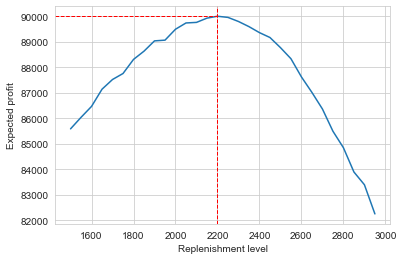

In [67]:
result1 = periodic_review(Product(1), 1500, 3000, step=50)
optimum_inv1 = optimum_inventory(Product(1), result1)
# optimum_inv
max_prof = max(result1['exp_profit'])
i = result1['exp_profit'].index(max_prof)
# result['replenishment_level'][i]
xx = [i for i in result1['replenishment_level']]
yy = [j for j in result1['exp_profit']]


plt.plot(xx, yy)
max_y = max(result1['exp_profit'])  # Find the maximum y value
i = result1['exp_profit'].index(max_prof)
max_x = result1['replenishment_level'][i]  # Find the x value corresponding to the maximum y value
plt.axhline(y=max_y,color='red', ls = '--', lw=1, xmin=0, xmax=(max_x - min(xx)) / (max(xx) - min(xx)))
plt.axvline(x=max_x,color='red',ls= '--', lw=1, ymin=0, ymax=(max_y - min(yy)) / (max(yy) - min(yy)))
plt.xlabel("Replenishment level (Units)")
plt.ylabel("Expected profit (Rupees)")
plt.show()

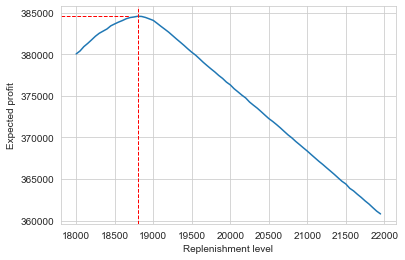

In [69]:
result2 = periodic_review(Product(2), 18000, 22000, step=50)
optimum_inv2 = optimum_inventory(Product(2), result2)
max_prof = max(result2['exp_profit'])
i = result2['exp_profit'].index(max_prof)
# result['replenishment_level'][i]

xx = [i for i in result2['replenishment_level']]
yy = [j for j in result2['exp_profit']]


plt.plot(xx, yy)
max_y = max(result2['exp_profit'])  # Find the maximum y value
i = result2['exp_profit'].index(max_prof)
max_x = result2['replenishment_level'][i]  # Find the x value corresponding to the maximum y value
plt.axhline(y=max_y,color='red', ls = '--', lw=1, xmin=0, xmax=(max_x - min(xx)) / (max(xx) - min(xx)))
plt.axvline(x=max_x,color='red',ls= '--', lw=1, ymin=0, ymax=(max_y - min(yy)) / (max(yy) - min(yy)))
plt.xlabel("Replenishment level (Units)")
plt.ylabel("Expected profit (Rupees)")

plt.show()

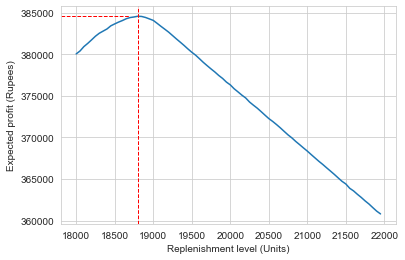

In [72]:
max_prof = max(result2['exp_profit'])
i = result2['exp_profit'].index(max_prof)
# result['replenishment_level'][i]

xx = [i for i in result2['replenishment_level']]
yy = [j for j in result2['exp_profit']]


plt.plot(xx, yy)
max_y = max(result2['exp_profit'])  # Find the maximum y value
i = result2['exp_profit'].index(max_prof)
max_x = result2['replenishment_level'][i]  # Find the x value corresponding to the maximum y value
plt.axhline(y=max_y,color='red', ls = '--', lw=1, xmin=0, xmax=(max_x - min(xx)) / (max(xx) - min(xx)))
plt.axvline(x=max_x,color='red',ls= '--', lw=1, ymin=0, ymax=(max_y - min(yy)) / (max(yy) - min(yy)))
plt.xlabel("Replenishment level (Units)")
plt.ylabel("Expected profit (Rupees)")

plt.show()

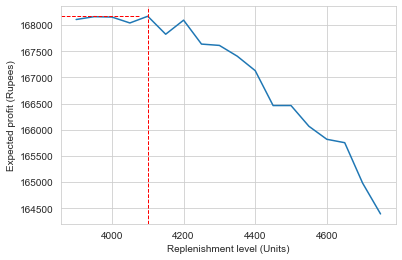

In [73]:
result3 = periodic_review(Product(3), 3900, 4800, step=50)
optimum_inv3 = optimum_inventory(Product(3), result3)
max_prof = max(result3['exp_profit'])
i = result3['exp_profit'].index(max_prof)
# result['replenishment_level'][i]

xx = [i for i in result3['replenishment_level']]
yy = [j for j in result3['exp_profit']]


plt.plot(xx, yy)
max_y = max(result3['exp_profit'])  # Find the maximum y value
i = result3['exp_profit'].index(max_prof)
max_x = result3['replenishment_level'][i]  # Find the x value corresponding to the maximum y value
plt.axhline(y=max_y,color='red', ls = '--', lw=1, xmin=0, xmax=(max_x - min(xx)) / (max(xx) - min(xx)))
plt.axvline(x=max_x,color='red',ls= '--', lw=1, ymin=0, ymax=(max_y - min(yy)) / (max(yy) - min(yy)))
plt.xlabel("Replenishment level (Units)")
plt.ylabel("Expected profit (Rupees)")

plt.show()

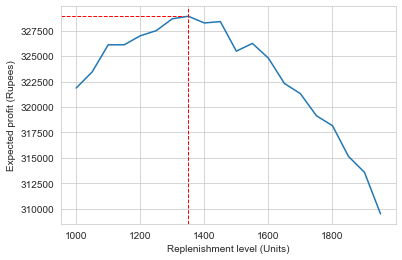

In [79]:
result4 = periodic_review(Product(4), 1000, 2000, step=50)
optimum_inv4 = optimum_inventory(Product(4), result4)
max_prof = max(result4['exp_profit'])
i = result4['exp_profit'].index(max_prof)
# result['replenishment_level'][i]

xx = [i for i in result4['replenishment_level']]
yy = [j for j in result4['exp_profit']]


plt.plot(xx, yy)
max_y = max(result4['exp_profit'])  # Find the maximum y value
i = result4['exp_profit'].index(max_prof)
max_x = result4['replenishment_level'][i]  # Find the x value corresponding to the maximum y value
plt.axhline(y=max_y,color='red', ls = '--', lw=1, xmin=0, xmax=(max_x - min(xx)) / (max(xx) - min(xx)))
plt.axvline(x=max_x,color='red',ls= '--', lw=1, ymin=0, ymax=(max_y - min(yy)) / (max(yy) - min(yy)))
plt.xlabel("Replenishment level (Units)")
plt.ylabel("Expected profit (Rupees)")

plt.show()

In [81]:
prod_1 = pd.DataFrame(optimum_inv1)
prod_2 = pd.DataFrame(optimum_inv2)
prod_3 = pd.DataFrame(optimum_inv3)
prod_4 = pd.DataFrame(optimum_inv4)

In [82]:
mc_optimum_inventory = pd.concat([prod_1, prod_2,prod_3, prod_4], ignore_index=True, axis=0)
mc_optimum_inventory

,Inventory,Expected Profit,Expected std dev of profit,Orders lost proportion
0,2200,89998.420270,4065.254873,0.062970
1,18800,384579.259149,880.152414,0.002324
2,4100,168169.243001,6608.784355,0.051121
3,1350,328924.559851,30969.597118,0.067149


In [83]:
def periodic_review_graph(product, review_dict):
    x = review_dict['replenishment_level']
    y = review_dict['exp_profit']
    z = review_dict['std_profit']
    plt.plot(x, y, color = 'blue')
    plt.fill_between(x, 
                     np.array(y) - np.array(z),
                     np.array(y) + np.array(z), 
                     color = 'blue',
                     alpha = 0.2)
    
    plt.axvline(x[y.index(max(y))], color ='black', lw = 1, ls = '--', alpha = 0.75)
    plt.axhline(max(y), color ='black', lw = 1, ls = '--', alpha = 0.75)
    
    plt.xlabel('Inventory level')
    plt.ylabel('Profit')
    
    plt.show()

1 Monte carlo simulation for Product 1 at optimum level of inventory (2200)

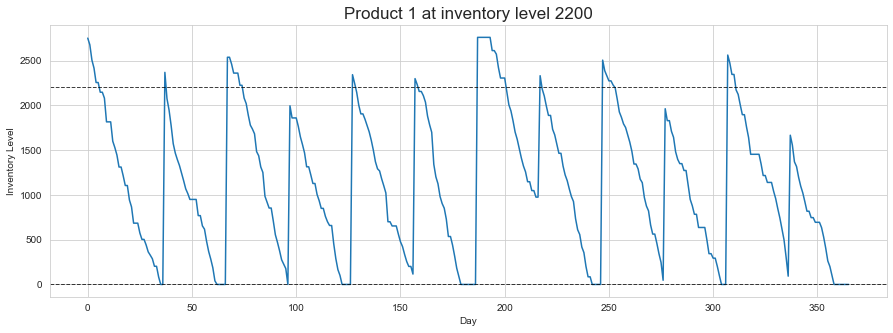

In [92]:
plot_mc = monte_carlo(Product(1), mc_optimum_inventory['Inventory'][0], review_period = 30)
plt.figure(figsize=(15,5))
plt.plot(plot_mc['inventory_level'])
plt.axhline(0, color ='black', lw = 1, ls = '--', alpha = 0.75)
plt.axhline(2200, color ='black', lw = 1, ls = '--', alpha = 0.75)
plt.xlabel("Day")
plt.ylabel("Inventory Level")
plt.title("Product 1 at inventory level 2200", fontsize=15)
plt.show()

### CONTINUOUS REVIEW

In [149]:
def monte_carlo_cr(product, Q, r): #Q = order quantity, r = reorder point
    inventory = product.starting_stock
    lead_demand = product.leadtime_demand
    lead_time = product.lead_time
    mean = product.mean
    std = product.std
    probability = product.probability
    
    data_dict = {'orders' : [], 'per_day_demand' : [], 'orders_lost' : [],
                 'quantity_sold' : [], 'inventory_level' : []} 
    
    out_of_stock = 0 # number of times store was out of stock for a product
    order_placed = False
    order_day = 0
    
    for d in range(1,366):
        day_demand = daily_demand(mean,std,probability)
        data_dict['per_day_demand'].append(day_demand)
        
        # Place order when inventory level reaches a certain threshold
        if inventory <= r and not order_placed:
            order_placed = True
            order_day = d
#             data_dict['orders'].append(Q)
            
        
        # If number of days elapsed since order placed = lead time, replenish the inventory with
        # order quantity Q
        if order_placed and ((d - order_day) == lead_time):
            data_dict['orders'].append(Q)
            inventory += Q
            order_placed = False
            order_day = 0
        
        # If daily demand can be fulfilled by the current inventory level, reduce the inventory
        # level by the demand.
        if inventory - day_demand >= 0:
            data_dict['quantity_sold'].append(day_demand)
            inventory -= day_demand
        
        # If demand cannot be fulfilled by the current inventory stock, quantity sold will be
        # the inventory stock left. Order lost = Daily demand - inventory level
        elif inventory - day_demand < 0:
            data_dict['quantity_sold'].append(inventory)
            data_dict['orders_lost'].append(day_demand - inventory)
            inventory = 0
            out_of_stock += 1
            
        data_dict['inventory_level'].append(inventory)
        
    return data_dict

In [150]:
def simulations_cr(product, Q, r ,number = 1000):
    orders_lost_proportion = []
    profit_per_simulation = []
    for num in range(number):
        data_dict = monte_carlo_cr(product, Q, r)
        orders_lost_proportion.append(sum(data_dict['orders_lost'])/sum(data_dict['per_day_demand']))
        profit_per_simulation.append(profit(product, data_dict))
        
    return orders_lost_proportion, profit_per_simulation

In [151]:
def continuous_review(product, Q, r, q_range, r_range, step = 50):
    q_lower_limit = Q - q_range
    q_upper_limit = Q + q_range
    r_lower_limit = r - r_range
    r_upper_limit = r + r_range
    
    cont_review_dict = {}
    
    for q in range(q_lower_limit, q_upper_limit, step):
        for r in range(r_lower_limit, r_upper_limit, step):
            sim = simulations_cr(product, Q, r)
            cont_review_dict[(q,r)] = [np.mean(sim[1]), np.std(sim[1]), np.mean(sim[0])]
            
    return cont_review_dict

In [152]:
cr_prod_1 = continuous_review(Product(1),2000, 600, 500, 300)

In [170]:
cr_prod_2 = continuous_review(Product(2),20500, 3700, 2000, 300)

In [158]:
cr_prod_3 = continuous_review(Product(3),4500,2600,500,500)

In [161]:
cr_prod_4 = continuous_review(Product(4),1500,700,500, 500 )

In [172]:
prod_1 = max(cr_prod_1.items(), key=operator.itemgetter(1))
prod_2 = max(cr_prod_2.items(), key=operator.itemgetter(1))
prod_3 = max(cr_prod_3.items(), key=operator.itemgetter(1))
prod_4 = max(cr_prod_4.items(), key=operator.itemgetter(1))

prod1_data = [prod_1[0][0], prod_1[0][1], prod_1[1][0], prod_1[1][1], prod_1[1][2]]
prod2_data = [prod_2[0][0], prod_2[0][1], prod_2[1][0], prod_2[1][1], prod_2[1][2]]
prod3_data = [prod_3[0][0], prod_3[0][1], prod_3[1][0], prod_3[1][1], prod_3[1][2]]
prod4_data = [prod_4[0][0], prod_4[0][1], prod_4[1][0], prod_4[1][1], prod_4[1][2]]

prod1_df = pd.DataFrame([prod1_data], columns=['Order quantity', 'Reorder point', 'Expected profit',
                                               'Standard deviation', 'Orders lost proportion'])
prod2_df = pd.DataFrame([prod2_data], columns=['Order quantity', 'Reorder point', 'Expected profit',
                                               'Standard deviation', 'Orders lost proportion'])
prod3_df = pd.DataFrame([prod3_data], columns=['Order quantity', 'Reorder point', 'Expected profit',
                                               'Standard deviation', 'Orders lost proportion'])
prod4_df = pd.DataFrame([prod4_data], columns=['Order quantity', 'Reorder point', 'Expected profit',
                                               'Standard deviation', 'Orders lost proportion'])

mc_optimum_inventory_cr = pd.concat([prod1_df, prod2_df, prod3_df, prod4_df], ignore_index=True, axis=0)

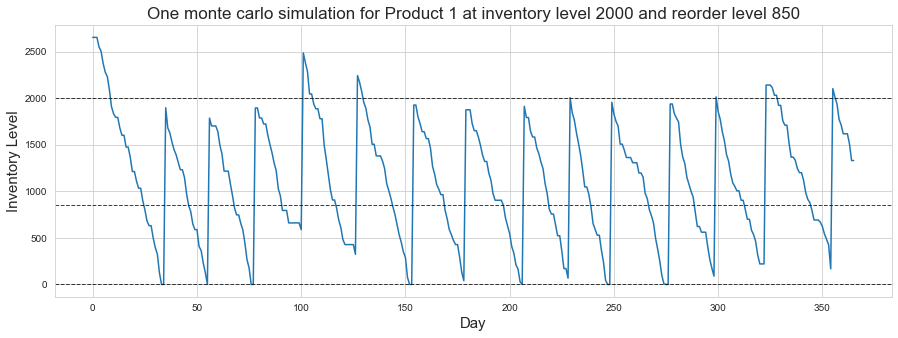

In [178]:
plot_mc_cr = monte_carlo_cr(Product(1), mc_optimum_inventory_cr['Order quantity'][0],mc_optimum_inventory_cr['Reorder point'][0] )
plt.figure(figsize=(15,5))
plt.plot(plot_mc_cr['inventory_level'])
plt.axhline(0, color ='black', lw = 1, ls = '--', alpha = 0.75)
plt.axhline(850, color ='black', lw = 1, ls = '--', alpha = 0.75)
plt.axhline(2000, color ='black', lw = 1, ls = '--', alpha = 0.75)
plt.xlabel("Day", fontsize = 15)
plt.ylabel("Inventory Level", fontsize = 15)
plt.title("One monte carlo simulation for Product 1 at inventory level 2000 and reorder level 850", fontsize=17)
plt.show()

In [11]:
# demand_leadtime = []    
# for idx , p in enumerate(column_names):
#     demand_leadtime.append(round(
#         (avg_demand[idx] * order_probability[idx] * prod_info['Lead Time'][idx]),2))
# prod_info['Avg Demand during leadtime'] = demand_leadtime

In [32]:
# prod_1 = max(cr_prod_1.items(), key=operator.itemgetter(1))
# prod_2 = max(cr_prod_2.items(), key=operator.itemgetter(1))
# prod_3 = max(cr_prod_3.items(), key=operator.itemgetter(1))
# prod_4 = max(cr_prod_4.items(), key=operator.itemgetter(1))


# mc_optimum_inventory_cr = pd.DataFrame(columns = ['Order quantity','Reorder point','Expected profit', 
#                                                   'Standard deviation', 'Orders lost proportion'])

# prod1_df = pd.DataFrame(prod_1[0][0], prod_1[0][1], prod_1[1][0], prod_1[1][1], prod_1[1][2])
# prod2_df = pd.DataFrame(prod_2[0][0], prod_2[0][1], prod_2[1][0], prod_2[1][1], prod_2[1][2])
# prod3_df = pd.DataFrame(prod_3[0][0], prod_3[0][1], prod_3[1][0], prod_3[1][1], prod_3[1][2])
# prod4_df = pd.DataFrame(prod_4[0][0], prod_4[0][1], prod_4[1][0], prod_4[1][1], prod_4[1][2])

# mc_optimum_inventory_cr = pd.concat([prod_1, prod_2,prod_3, prod_4], ignore_index=True, axis=0)
# mc_optimum_inventory_cr.columns = ['Order quantity','Reorder point','Expected profit', 
#                                    'Standard deviation', 'Orders lost proportion']

In [34]:
fig = plt.figure()
ax = plt.add_subplot(111,projection = '3d')

order_quantity = [x[0] for x in list(cr_prod_1.keys())]
reorder_point = [y[0] for y in list(cr_prod_1.keys())]
exp_profit = [z[0] for z in list(cr_prod_1.keys())]

ax.set_xlabel('Order Quantity')
ax.set_ylabel('Reorder Point')
ax.set_zlabel('Profit')

ax.scatter(order_quantity,reorder_point,exp_profit)
plt.show()

In [58]:
a = {(2,2) : [0.4,5.2, 0.3,0.1], (2,3) : [2.4, 0.2, 0.8, 0.2], (2,0) : [2.5, 10.2, 0.5, 0.4], (1,2) : [5, 1.2, 0.3, 0.4]}
b = max(a.items(), key=operator.itemgetter(1))
b

((1, 2), [5, 1.2, 0.3, 0.4])

a = {(2,2) : [0.4,5.2, 0.3,0.1], (2,3) : [2.4, 0.2, 0.8, 0.2], (2,0) : [2.5, 10.2, 0.5, 0.4], (1,2) : [5, 1.2, 0.3, 0.4]}
b = max(a.items(), key=operator.itemgetter(1))
b[0]

a.items() returns all the key value pairs of the dictionary

operator.itemgetter(1) is used to compare based on a particular attribute/index. Since we are working with a dictionary, the integer in brackets signifies the either the key (0) or value(1) based on which the comparision will be made.

So our code first looks at all the key value pairs of the dictionary. Then, it looks at the index specified by itemgetter. If it is 0, it will choose the key with the max value and if it is 1, it will choose the value with the max value.

In [ ]:
# r is the replenishment level. The threshold below which inventory needs to be ordered.
def threshold_r(product, Q, low_r, high_r, step = 10, number = 1000):
    
    threshold_dict = {'threshold_r' : [x for x in range(low_r, high_r, step = 10)], 
                      'avg_profit_per_threshold_level' : [], 
                      'avg_orders_lost_proportion_per_threshold_level' : []}
    
    for r in range(low_r, high_r, step):
        sim = simulations(product, Q, r ,number = 1000)
        threshold_dict['avg_profit_per_threshold_level'].append(np.mean(sim[1]))
        threshold_dict['avg_orders_lost_proportion_per_threshold_level'].append(np.mean(sim[0])) 
                                      
    return threshold_dict

In [ ]:
def continuous_review(product, lower_limit, upper_limit, step=50, number=1000):
    cont_review_dict = {'replenishment_level' : [q for q in range(lower_limit, upper_limit, step)],
                        'avg_threshold' : [], 'exp_profit' : [], 'std_profit' : [], 
                        'avg_order_lost_proportion' : []}
    
    for Q in cont_review_dict['replenishment_level']:
        thresh = threshold_r(product, Q, low_r, high_r, step = 10, number = 1000)
        i = thresh['avg_profit_per_simulation'].index(max(thresh['avg_profit_per_simulation']))
        cont_review_dict['avg_threshold'].append(thresh['threshold_r'][i])
        cont_review_dict['exp_profit'].append(np.max(thresh['avg_profit_per_simulation']))
        cont_review_dict['std_profit'].append(np.std(thresh['avg_profit_per_simulation']))
        cont_review_dict['avg_order_lost_proportion'].append(thresh['avg_orders_lost_proportion_per_threshold_level'])

In [169]:
mc_optimum_inventory_cr

,Order quantity,Reorder point,Expected profit,Standard deviation,Orders lost proportion
0,2000,850,111736.450207,8759.042651,0.021057
1,21200,3400,455696.791398,64271.816151,0.040577
2,4900,2250,193249.759698,10675.676256,0.044395
3,1450,1150,382683.513858,42389.704062,0.018268
